# Miniproject 1: Image Classification

## Introduction

### Important dates:

- Project release: Friday, 15th March 2019
- **Submission deadline**: Monday, 29th April 2019, 11:59 pm

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://yann.lecun.com/exdb/mnist/). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used as a first test for new classification algorithms. 
We follow this tradition to investigate the performance of artificial neural networks of different complexity on MNIST. However, since MNIST is too easy for accessing the full power of modern machine learning algorithms (see e.g. [this post](https://twitter.com/goodfellow_ian/status/852591106655043584)) we will extend our analysis to the recently introduced, harder [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/). Feel free to gain inspiration from the [Keras example directory](https://github.com/keras-team/keras/tree/master/examples) for your implementations.
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "convolutional neural network", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night (or on an external server).

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. Provide clear and concise answers respecting the indicated maximum length (answers to the questions should be below the line that says "Answer to question ...").

**The submitted notebook must be run by you!** We will only do random tests of your code and not re-run the full notebook. There will be fraud detection sessions at the end of the semester.

### Your names

**Before you start**: please enter your full name(s) in the field below.

In [1]:
student1 = "Zeya Yin"
student2 = "Olivier Cloux"

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [2]:
%matplotlib inline

import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io
import pickle

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.optimizers import SGD, Adam
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


### Plotting

In [3]:
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 28, ydim = 28,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j])%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k])%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig


## Exercise 1: Data import and visualization (4 points)

### Description

### Loading the data

The datasets we use in this project (MNIST, Fashion-MNIST) consists of grayscale images with 28x28 pixels. Keras comes with a convenient in-built [data importer](https://keras.io/datasets/) for common datasets.

1. As a warm-up exercise, use this importer to (down-)load the MNIST and Fashion-MNIST dataset. Assign useful variables to test & train images and labels for both datasets respectively. (2 pts)
2. Use the corresponding plotting function defined above to plot some samples of the two datasets. What do the green digits at the bottom left of each image indicate? (1 sentence max.) (2 pts)

The low resolution (and grayscale) of the images certainly misses some information that could be helpful for classifying the images. However, since the data has lower dimensionality due to the low resolution, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish.



### Solution

In [4]:
from keras.datasets import mnist
from keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion_test) = fashion_mnist.load_data()

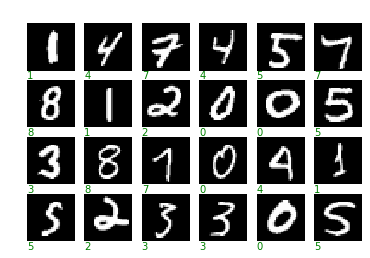

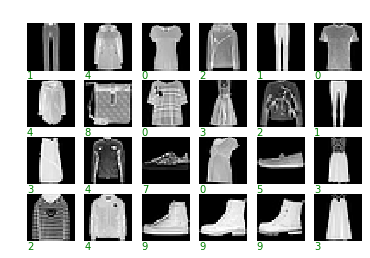

In [5]:
plot_some_samples(x_test, y_test);
plot_some_samples(x_fashion_train, y_fashion_train);

**Answer to question 2:**

They correspond to the label attached to each image

**Data pre-processing**: To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing). Furthermore we reshape (flatten) the input images to input vectors and rescale the data into the range [0,1].

In [6]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

y_fashion_train = keras.utils.to_categorical(y_fashion_train)
y_fashion_test = keras.utils.to_categorical(y_fashion_test)


In [7]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])/np.max(x_train)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])/np.max(x_test)

x_fashion_train = x_fashion_train.reshape(x_fashion_train.shape[0], x_fashion_train.shape[1]*x_fashion_train.shape[2])/np.max(x_fashion_train)
x_fashion_test = x_fashion_test.reshape(x_fashion_test.shape[0], x_fashion_test.shape[1]*x_fashion_test.shape[2])/np.max(x_fashion_test)

In [8]:
x_train.shape

(60000, 784)

## Exercise 2: No hidden layer (10 points)

### Description

Define and fit a model without a hidden layer (since we will use multi-layer models later in this project, you can define a general constructor function for models with an arbitrary number of hidden layers already at this point). (1 pt for each step)

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices)`. Explain the green and red digits at the bottom of each image.
9. Repeat the above steps for fitting the network to the Fashion-MNIST dataset.


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Unable to recover, computing...
Saving results


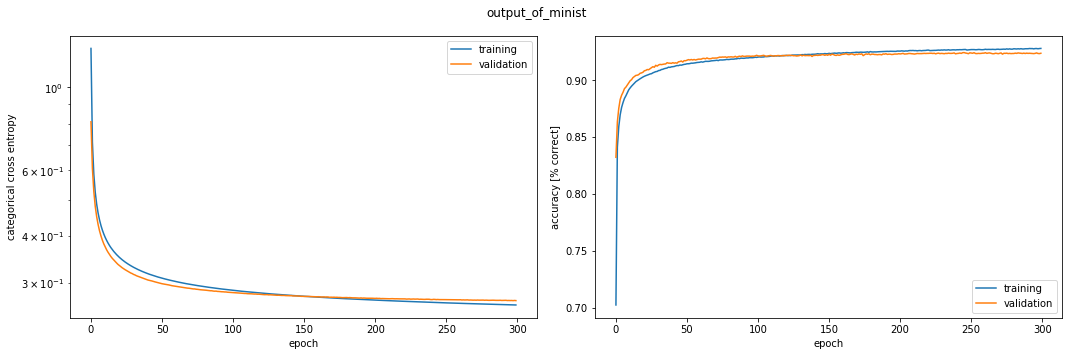

In [9]:
##### for minst ######
model = Sequential()
model.add(Dense(10,activation='softmax',input_shape=(784,)))
model.summary()
model.compile(loss='categorical_crossentropy',optimizer=SGD(),metrics=['accuracy'])

hist_filename = "Histories/ex2-mnist.pickle"
weights_filename = "Weights/ex2-mnist.h5"
try: #try to recover from previous run
    with open(hist_filename, 'rb') as f:
        history = pickle.load(f)
    model.load_weights(weights_filename)
    print("Recovered history and weights")
except (FileNotFoundError, OSError):
    #unable to recover, compute
    print("Unable to recover, computing...")
    history = model.fit(x_train, y_train,
                        batch_size=128,
                        epochs=300,
                        verbose=2,
                        validation_data=(x_test, y_test))
    #save history and weights
    print("Saving results")
    with open(hist_filename, 'wb') as f:
        pickle.dump(history, f)
    model.save_weights(weights_filename)

plot_history(history,'output_of_minist');

**Answer to 8:**

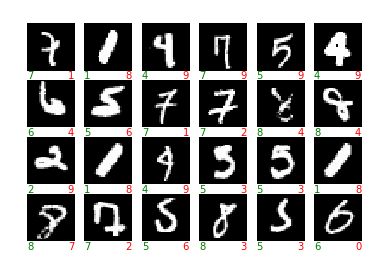

In [10]:
raw_predictions = model.predict(x_test)
predictions = np.zeros_like(raw_predictions)
predictions[np.arange(len(predictions)), np.argmax(raw_predictions, axis=1)] = 1
wrong_predictions = np.ravel(np.argwhere((predictions != y_test).any(axis=1)))
plot_some_samples(x_test, y_test, raw_predictions, wrong_predictions);

The green numbers correspond to the true label of each data point, while the red corresponds to the label predicted by the NN.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Unable to recover, computing...


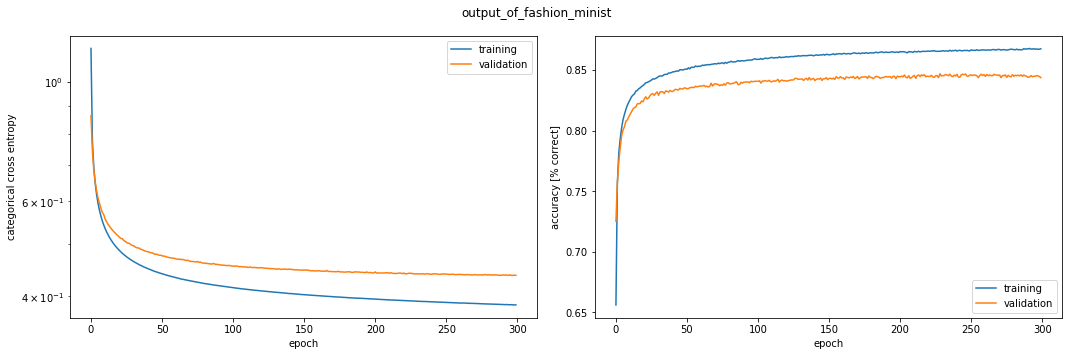

In [11]:
##### for fashion_minst ######
model = Sequential()
model.add(Dense(10,activation='softmax',input_shape=(784,)))
model.summary()
model.compile(loss='categorical_crossentropy',optimizer=SGD(),metrics=['accuracy'])

hist_filename = "Histories/ex2-fashion.pickle"
weights_filename = "Weights/ex2-fashion.h5"
try: #try to recover from previous run
    with open(hist_filename, 'rb') as f:
        history = pickle.load(f)
    model.load_weights(weights_filename)
    print("Recovered history and weights")
except (FileNotFoundError, OSError):
    #unable to recover, compute
    print("Unable to recover, computing...")
    history = model.fit(x_fashion_train, y_fashion_train,
                        batch_size=128,
                        epochs=300,
                        verbose=2,
                        validation_data=(x_fashion_test, y_fashion_test))
    #save history and weights
    with open(hist_filename, 'wb') as f:
        pickle.dump(history, f)
    model.save_weights(weights_filename)
plot_history(history,'output_of_fashion_minist');

**Answer to question 8:**

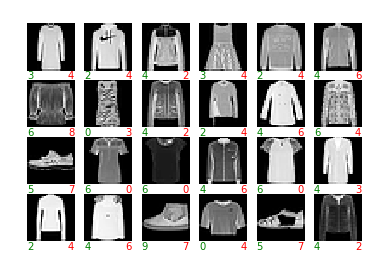

In [12]:
raw_predictions = model.predict(x_fashion_test)
predictions = np.zeros_like(raw_predictions)
predictions[np.arange(len(predictions)), np.argmax(raw_predictions, axis=1)] = 1
wrong_predictions = np.ravel(np.argwhere((predictions != y_fashion_test).any(axis=1)))
plot_some_samples(x_fashion_test, y_fashion_test, raw_predictions, wrong_predictions);

The green numbers correspond to the true label of each data point, while the red corresponds to the label predicted by the NN.

## Exercise 3: One hidden layer, different optizimizers & overfitting (10 points)

### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 128 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to display your model in a compact way. (1 pt)
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent (SGD). (1pt)
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam). (1pt)
4. Plot the learning curves of SGD with a reasonable learning rate (i.e. in the range [0.01,0.1]) together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot. (2pts)
5. Answer the questions below. (4pts)
6. Run the network (using the Adam optimizer) on the Fashion-MNIST dataset and plot the learning curves using the plot_history function defined above. (1pt)

### Solution

In [13]:
def modeling(optimizer, dataset="mnist"):
    model = Sequential()
    model.add(Dense(128,activation='relu',input_shape=(784,)))
    model.add(Dense(10,activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    if dataset == "mnist":
        x_tr, y_tr = x_train, y_train
        x_te, y_te = x_test, y_test
    elif dataset == "fashion":
        x_tr, y_tr = x_fashion_train, y_fashion_train
        x_te, y_te = x_fashion_test, y_fashion_test
    else:
        raise Exception("Dataset {} not known".format(dataset))
    history = model.fit(x_tr, y_tr,
                        batch_size=128,
                        epochs=50,
                        verbose=0,
                        validation_data=(x_te, y_te))
    return history

#### Question 2

In [14]:
filename = "Histories/ex3-histories.pickle"
try:
    with open(filename, "rb") as f:
        histories = pickle.load(f)
except FileNotFoundError:
    histories = {'SGD': {}}

In [15]:
##### for minst ######
for lr in np.logspace(-7,1,50):
    approx = "{:.10f}".format(lr)
    if approx in histories['SGD']:
        print("Retrieved SGD with lr={}".format(approx))
    else:
        print("Training with Learning rate = {}".format(lr))
        history = modeling(SGD(lr=lr))
        histories['SGD'][approx] = history
        with open(filename, "wb") as f:
            pickle.dump(histories, f)

Training with Learning rate = 1e-07
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Training with Learning rate = 1.4563484775012443e-07
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________

Training with Learning rate = 1.3257113655901082e-05
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_30 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Training with Learning rate = 1.9306977288832496e-05
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_32 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
________________________

Training with Learning rate = 0.0017575106248547893
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_56 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Training with Learning rate = 0.0025595479226995332
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_58 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
__________________________

Training with Learning rate = 0.23299518105153671
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_82 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Training with Learning rate = 0.3393221771895323
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_83 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_84 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_______________________________

#### Question 3

In [16]:
if 'Adam' in histories:
    print("Adam retrieved")
else:
    histories['Adam'] = modeling(Adam())
    with open(filename, "wb") as f:
        pickle.dump(histories, f)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_103 (Dense)            (None, 128)               100480    
_________________________________________________________________
dense_104 (Dense)            (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [17]:
# This plotting routine might help you ...
def comparison_plot(history_sgd, history_adam, label1, label2, title):
    fig, ax1, ax2 = prepare_standardplot(title, "epochs")
    ax1.plot(history_sgd.history['loss'], label=label1 + ' training')
    ax1.plot(history_sgd.history['val_loss'], label=label1 + ' validation')
    ax1.plot(history_adam.history['loss'], label=label2 + ' training')
    ax1.plot(history_adam.history['val_loss'], label=label2 + ' validation')
    ax2.plot(history_sgd.history['acc'], label=label1 + ' training')
    ax2.plot(history_sgd.history['val_acc'], label=label1 + ' validation')
    ax2.plot(history_adam.history['acc'], label=label2 + ' training')
    ax2.plot(history_adam.history['val_acc'], label=label2 + ' validation')
    finalize_standardplot(fig, ax1, ax2)
    return fig

#### Question 4

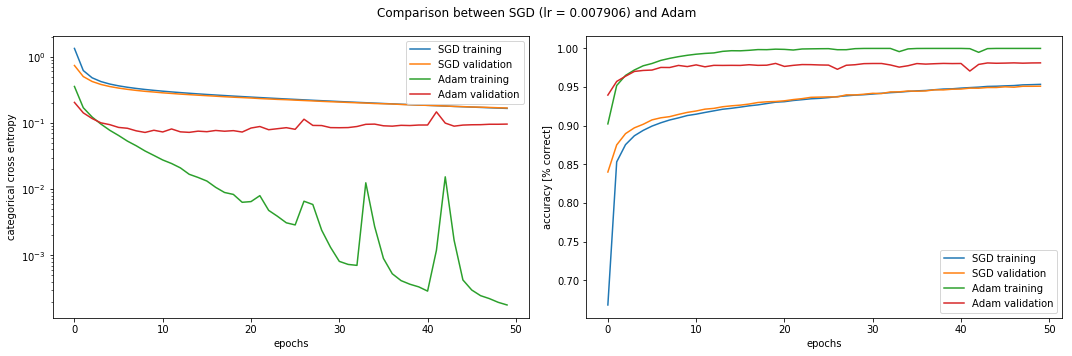

In [18]:
comparison_plot(histories['SGD']['0.0079060432'], histories['Adam'], 'SGD'.format(0.0079060432), 'Adam', 'Comparison between SGD (lr = {:5f}) and Adam'.format(0.0079060432));

#### Question 5
**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence each (double click this markdown cell to edit).

**Answer**:

A) Each step miss the optimal point by overjumping, creating a divergence and never improving accuracy.

B) Each step is awfully small, which blocks the iterations from doing any form of progress in a reasonable time.

**Question**: At which epoch (approximately) does the Adam optimizer start to overfit (on MNIST)? Please answer with one full sentence.

**Answer**: When the training accuracy and loss become better than the validation and loss starts to grow again, so after a few epoche (~5)


**Question**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**: When overfitting appears, we see a training loss ridiculously close to 0, while training precision goes to 1. It may not be a problem if the testing loss/accuracy followed, but they are clearly stuck at some threshold. Also, when the loss starts to grow again we have hit overfitting.

#### Question 6

In [19]:
if 'Adam_fashion' in histories:
    fashion_adam = histories['Adam_fashion']
    print("Adam retrieved")
else:
    fashion_adam =modeling(Adam(), dataset="fashion")
    histories['Adam_fashion'] = fashion_adam
    with open(filename, "wb") as f:
        pickle.dump(histories, f)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_105 (Dense)            (None, 128)               100480    
_________________________________________________________________
dense_106 (Dense)            (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [20]:
fashion_adam

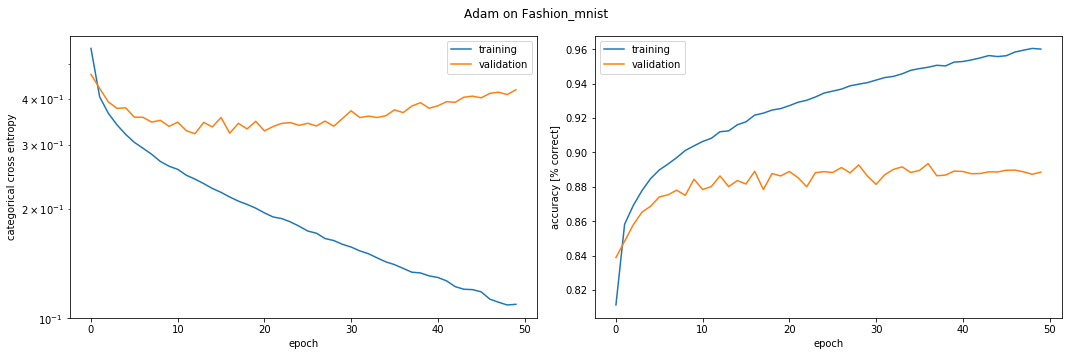

In [21]:
plot_history(fashion_adam, 'Adam on Fashion_mnist');

## Exercise 4: Model performance as a function of number of hidden neurons (8 points)

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models (e.g. 5) with different hidden layer sizes (between 10 and 1000 hidden neurons) to the MNIST dataset. You may use the Adam optimizer and a meaningful number of epochs (overfitting!). (3 pts)
2. Plot the best validation loss and accuracy versus the number of hidden neurons. Is the observed trend in accordance with the [general approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem)? If not, what might be practical reasons for the deviation? (2 sentences max.) (3 pts)
3. Repeat steps 1. & 2. for the Fashion-MNIST dataset. (2 pts)

In this exercise we fit each model only for one initialization and random seed. In practice one would collect some statistics (e.g. 25-, 50-, 75-percentiles) for each layer size by fitting each model several times with different initializations and the random seeds. You may also want to do this here. It is a good exercise, but not mandatory as it takes quite a bit of computation time.

### Solution

In [22]:
def varying_layer_size(hidden_neurons=10, dataset="mnist"):
    model = Sequential()
    model.add(Dense(hidden_neurons,activation='relu',input_shape=(784,)))
    model.add(Dense(10,activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])
    if dataset == "mnist":
        x_tr, y_tr = x_train, y_train
        x_te, y_te = x_test, y_test
    elif dataset == "fashion":
        x_tr, y_tr = x_fashion_train, y_fashion_train
        x_te, y_te = x_fashion_test, y_fashion_test
    else:
        raise Exception("Dataset {} not known".format(dataset))
    return model.fit(x_tr, y_tr,
                        batch_size=128,
                        epochs=20,
                        verbose=0,
                        validation_data=(x_te, y_te))


In [23]:
######################for minst################################
filename = "Histories/ex4-mnist-all.pickle"
try:
    with open(filename ,'rb') as f:
        mnist_various_neurons = pickle.load(f)
except FileNotFoundError:
    mnist_various_neurons = {}

for n in [10,20,75,100,120,250,350,500,550,600,650,700,750,800,900,950,1000]:
    if n in mnist_various_neurons:
        print("Retrieved for {} neurons".format(n))
    else:
        mnist_various_neurons[n] = varying_layer_size(n, 'mnist')
        with open(filename, 'wb') as f:
            pickle.dump(mnist_various_neurons, f)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_107 (Dense)            (None, 10)                7850      
_________________________________________________________________
dense_108 (Dense)            (None, 10)                110       
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_109 (Dense)            (None, 20)                15700     
_________________________________________________________________
dense_110 (Dense)            (None, 10)                210       
Total params: 15,910
Trainable params: 15,910
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Laye

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_135 (Dense)            (None, 900)               706500    
_________________________________________________________________
dense_136 (Dense)            (None, 10)                9010      
Total params: 715,510
Trainable params: 715,510
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_137 (Dense)            (None, 950)               745750    
_________________________________________________________________
dense_138 (Dense)            (None, 10)                9510      
Total params: 755,260
Trainable params: 755,260
Non-trainable params: 0
_________________________________________________________________
________________________________________________________________

In [24]:
######################for fashion################################
filename = "Histories/ex4-fashion-all.pickle"
# try to retrieve a result
try:
    with open(filename, 'rb') as f:
        fashion_various_neurons = pickle.load(f)
except FileNotFoundError:
    fashion_various_neurons = {}

#for some number of neurons
for n in [10,20,75,100,120,250,350,500,550,600,650,700,750,800,900,950,1000]:
    if n in fashion_various_neurons:
        #already computed
        print("Retrieved for {} neurons".format(n))
    else:
        #need to compute and 
        fashion_various_neurons[n] = varying_layer_size(n, 'fashion')
        with open(filename, 'wb') as f:
            pickle.dump(fashion_various_neurons, f)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_141 (Dense)            (None, 10)                7850      
_________________________________________________________________
dense_142 (Dense)            (None, 10)                110       
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_143 (Dense)            (None, 20)                15700     
_________________________________________________________________
dense_144 (Dense)            (None, 10)                210       
Total params: 15,910
Trainable params: 15,910
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Laye

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_169 (Dense)            (None, 900)               706500    
_________________________________________________________________
dense_170 (Dense)            (None, 10)                9010      
Total params: 715,510
Trainable params: 715,510
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_171 (Dense)            (None, 950)               745750    
_________________________________________________________________
dense_172 (Dense)            (None, 10)                9510      
Total params: 755,260
Trainable params: 755,260
Non-trainable params: 0
_________________________________________________________________
________________________________________________________________

#### Question 2

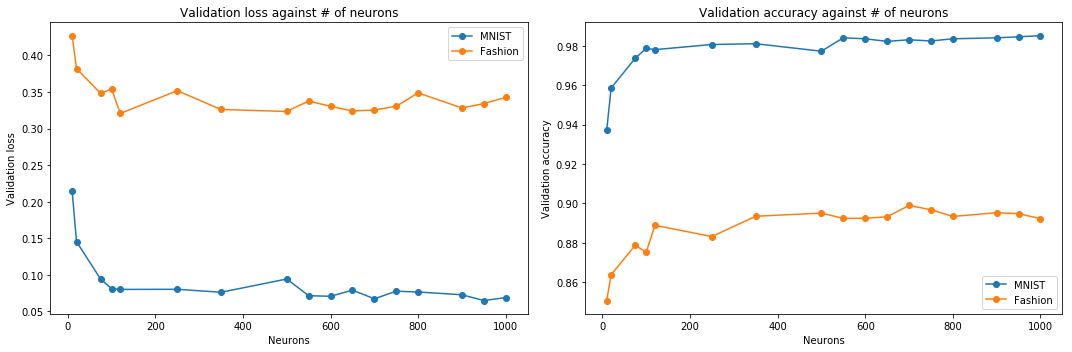

In [25]:
plt.figure(figsize=(15,5))
plt.subplot(121)
best_losses = [mnist_various_neurons[n].history['val_loss'][-1] for n in sorted(mnist_various_neurons)]
plt.plot(sorted(mnist_various_neurons.keys()), best_losses, 'o-', label="MNIST")
best_losses = [fashion_various_neurons[n].history['val_loss'][-1] for n in sorted(fashion_various_neurons)]
plt.plot(sorted(fashion_various_neurons.keys()), best_losses, 'o-', label="Fashion")
plt.legend()
plt.xlabel("Neurons")
plt.ylabel('Validation loss')
plt.title("Validation loss against # of neurons")

plt.subplot(122)
best_acc = [mnist_various_neurons[n].history['val_acc'][-1] for n in sorted(mnist_various_neurons)]
plt.plot(sorted(mnist_various_neurons.keys()), best_acc, 'o-', label="MNIST")
best_acc = [fashion_various_neurons[n].history['val_acc'][-1] for n in sorted(fashion_various_neurons)]
plt.plot(sorted(fashion_various_neurons.keys()), best_acc, 'o-', label="Fashion")
plt.legend()
plt.xlabel('Neurons')
plt.ylabel('Validation accuracy')
plt.title("Validation accuracy against # of neurons")
plt.tight_layout()
plt.show()

**Answer to question 2:**
_For MNIST_, we see that we reach close to a perfect accuracy with no loss (respectively ~0.98 and 0.07 respectively). Supposing there exists a linear function mapping the pixels to their label, the difference between our model and the reality is $\sim\epsilon$. Thus the trend is in accordance with the theorem.

_For Fashion-MNIST_ however, the prediction aren't as good, with about 0.89 accuracy and 0.33 loss, which can't be called "equal at $\epsilon$-close". A possible reason for the smaller precision is that the Fashion-MNIST is a much more complicated dataset, and can't be approximated by a simple neural network. While MNIST only really requires a few pixels for identification (see https://gist.github.com/dgrtwo/aaef94ecc6a60cd50322c0054cc04478), Fashion-MNIST has much more variance accross one label, and thus requires more complex networks.

## Exercise 5: Going deeper: tricks and regularization (8 points)

### Description

Adding hidden layers to a deep network does not necessarily lead to a straight-forward improvement of performance. Overfitting can be counteracted with regularization and dropout. Batch normalization is supposed to mainly speed up convergence. Since the MNIST dataset is almost perfectly solved already by a one-hidden-layer network we use the Fashion-MNIST dataset in this exercise.

1. Add one or two hidden layers with 50 hidden neurons (each) and train the network for a sufficiently long time (at least 100 epochs). Since deep models are very expressive you will most probably encounter overfitting. Try to improve the best validation scores of the model (even if it is only a minor improvement) by experimenting with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases. (4 pts)
2. After you have found good settings, plot the learning curves for both models, naive (=no tricks/regularization) and tuned (=tricks + regularized), preferably together in a comparison plot. Discuss your results; refer to the model performance with only 1 hidden layer. (2 sentences max.) (2pts)
3. Fit your best performing (probably regularized deep) model also to MNIST for having a reference for the next exercise. Plot the resulting learning curves. (2 pts)

### Solution

#### Question 1

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_175 (Dense)            (None, 50)                39250     
_________________________________________________________________
dense_176 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_177 (Dense)            (None, 10)                510       
Total params: 42,310
Trainable params: 42,310
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 57us/step - loss: 0.6030 - acc: 0.7922 - val_loss: 0.4680 - val_acc: 0.8341
Epoch 2/50
60000/60000 [==============================] - 1s 21us/step - loss: 0.4159 - acc: 0.8535 - val_loss: 0.4345 - val_acc: 0.8463
Epoch 3/50
60000/60000 [==============================] - 1s 21us/step - loss:

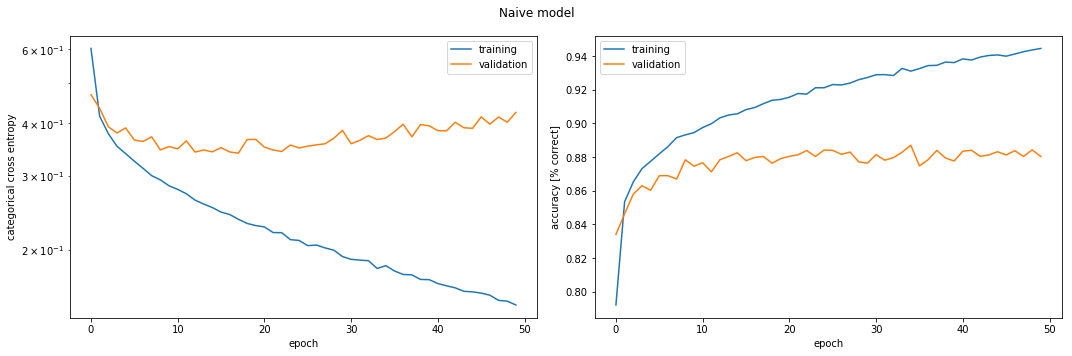

In [26]:
def naive():
    model = Sequential()
    model.add(Dense(50,activation='relu',input_shape=(784,)))
    model.add(Dense(50,activation='relu'))
    model.add(Dense(10,activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])

    x_tr, y_tr = x_fashion_train, y_fashion_train
    x_te, y_te = x_fashion_test, y_fashion_test
    history = model.fit(x_tr, y_tr,
                        batch_size=128,
                        epochs=50,
                        verbose=1,
                        validation_data=(x_te, y_te))
    return history, model
filename = "Histories/ex5-naive.pickle"
try:
    with open(filename, 'rb') as f:
        two_layers = pickle.load(f)
except FileNotFoundError:
    two_layers=naive()
    with open(filename, 'wb') as f:
        pickle.dump(two_layers, f)
plot_history(two_layers[0], "Naive model");
score = two_layers[1].evaluate(x_fashion_test, y_fashion_test)
print("Score is {}".format(score))

In [27]:
from keras import regularizers

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_178 (Dense)            (None, 50)                39250     
_________________________________________________________________
dense_179 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_180 (Dense)            (None, 10)                510       
Total params: 42,310
Trainable params: 42,310
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/70
 - 3s - loss: 0.9761 - acc: 0.7850 - val_loss: 0.6744 - val_acc: 0.8230
Epoch 2/70
 - 1s - loss: 0.5909 - acc: 0.8378 - val_loss: 0.5623 - val_acc: 0.8363
Epoch 3/70
 - 1s - loss: 0.5146 - acc: 0.8500 - val_loss: 0.5469 - val_acc: 0.8248
Epoch 4/70
 - 1s - loss: 0.4733 - acc: 0.8584 - val_loss: 0.5144 - val_acc: 0.8328
Epoch 5/70
 - 1s - l

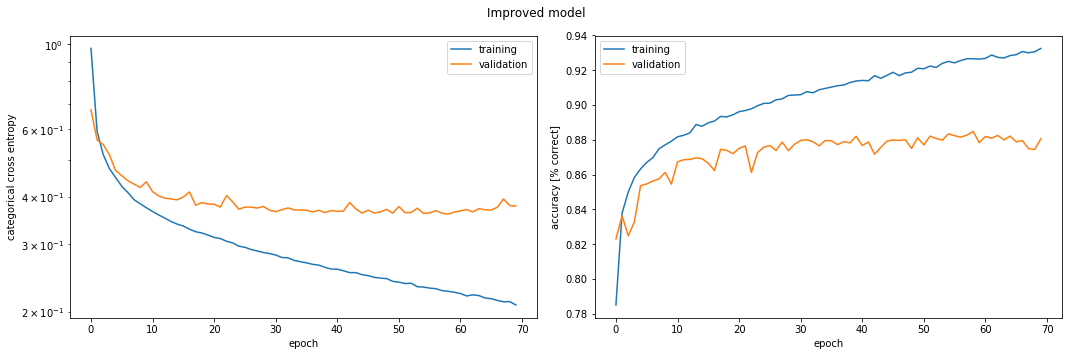

In [28]:
def improved():
    model = Sequential()
    model.add(Dense(50,activation='relu',input_shape=(784,)))
    model.add(Dense(50,activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.5))
    model.add(Dense(10,activation='softmax', kernel_regularizer=regularizers.l2(0.05)))
    model.summary()
    model.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])

    x_tr, y_tr = x_fashion_train, y_fashion_train
    x_te, y_te = x_fashion_test, y_fashion_test
    history = model.fit(x_tr, y_tr,
                        batch_size=128,
                        epochs=70,
                        verbose=2,
                        validation_data=(x_te, y_te))
    return history, model
improv1 = improved()
plot_history(improv1[0], "Improved model");
score = improv1[1].evaluate(x_fashion_test, y_fashion_test)
print("Score is {}".format(score))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_181 (Dense)            (None, 50)                39250     
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
dense_182 (Dense)            (None, 50)                2550      
_________________________________________________________________
batch_normalization_2 (Batch (None, 50)                200       
_________________________________________________________________
dense_183 (Dense)            (None, 10)                510       
Total params: 42,710
Trainable params: 42,510
Non-trainable params: 200
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
 - 4s - loss: 0.5255 - acc: 0.8179 - val_loss: 0.4782 - val_acc: 0.8316
Epo

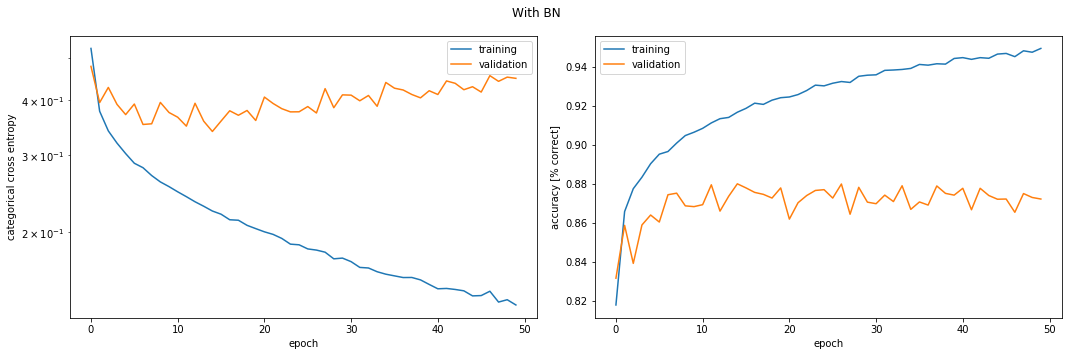

In [29]:
def BN_model():
    model = Sequential()
    model.add(Dense(50,activation='relu',input_shape=(784,)))
    model.add(BatchNormalization())
    model.add(Dense(50,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(10,activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])

    x_tr, y_tr = x_fashion_train, y_fashion_train
    x_te, y_te = x_fashion_test, y_fashion_test
    history = model.fit(x_tr, y_tr,
                        batch_size=128,
                        epochs=50,
                        verbose=2,
                        validation_data=(x_te, y_te))
    return history, model
improv2 = BN_model()
plot_history(improv2[0], 'With BN');
score = improv2[1].evaluate(x_fashion_test, y_fashion_test)
print("Score is {}".format(score))

## Exercise 6: Convolutional neural networks (CNNs) (10 points)

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with different architectures and parameters. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples). (4 pts)
2. Plot the learning curves of the convolutional neural network for MNIST and Fashion-MNIST. (4 pts)
3. How does the CNN performance compare to the so far best performing (deep) neural network model for the two data sets? (2 sentences max.) (2 pts)

### Solution

Try 2COV with different kernel

In [30]:
img_rows = 28
img_cols = 28
x_train_r = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_fashion_train_r = x_fashion_train.reshape(x_fashion_train.shape[0],img_rows,img_cols,1)
x_test_r = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
x_fashion_test_r = x_fashion_test.reshape(x_fashion_test.shape[0],img_rows,img_cols,1)
    
def first_layers(kernel_size=3, pooling=2, act ='relu'):    
    model = Sequential()
    model.add(Conv2D(32, (kernel_size, kernel_size),activation=act, input_shape=(28,28,1),name = "Conv1"))
    #model.add(BatchNormalization(axis=-1))
    model.add(Dropout(0.5))
    model.add(Conv2D(64, (kernel_size, kernel_size), activation = act ,name = "Conv2"))
    model.add(MaxPooling2D(pool_size=(pooling,pooling)))
    return model
    
def build_2cov(kernel_size=3, pooling=2, dataset="mnist", act ='relu'):   
    model = first_layers(kernel_size,pooling, act)
    model.add(Flatten())
    #model.add(BatchNormalization(axis=-1))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation= act))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    if dataset == "mnist":
        x_tr, y_tr = x_train_r, y_train
        x_te, y_te = x_test_r, y_test
    elif dataset == "fashion":
        x_tr, y_tr = x_fashion_train_r, y_fashion_train
        x_te, y_te = x_fashion_test_r, y_fashion_test
    else:
        raise Exception("Dataset {} not known".format(dataset))
     
    #checkpoints
#     filepath="Checkpoints/"+checkpoint_name+"-{epoch:02d}-{val_acc:.5f}.hdf5"
#     checkpoints = keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    
#     callbacks = [checkpoints]
    history = model.fit(x_tr, y_tr, batch_size=128, epochs=30, verbose=1, validation_data=(x_te, y_te))
    
    return history

In [31]:

######## check for different kernel size############ 
######################for minst####################################
filename = "Histories/ex6_minist_various_kernel.pickle"
try:
    with open(filename, 'rb') as f:
        print('Recovering...')
        mnist_various_kernel = pickle.load(f)
except FileNotFoundError:
    print('Unable to recover, computing')
    mnist_various_kernel= {}

for n in [1,3,5]:
    if n not in mnist_various_kernel:
        print("Computing for n={}".format(n))
        mnist_various_kernel[n] = build_2cov(n,2,'mnist','relu')
        with open(filename,'wb') as f:
            pickle.dump(mnist_various_kernel, f)
    else:
        print("Recovered for n={}".format(n))
#plot_history(mnist_various_kernel[1],'Mnist dataset with 2 convolution and kernel size=1');
#plot_history(mnist_various_kernel[3],'Mnist dataset with 2 convolution and kernel size=3'); 
#plot_history(mnist_various_kernel[5],'Mnist dataset with 2 convolution and kernel size=5');

Unable to recover, computing
Computing for n=1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 28, 28, 32)        64        
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 32)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 28, 28, 64)        2112      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12544)             0         
_________________________________________________________________
dense_184 (Dense)            

Epoch 7/30
60000/60000 [==============================] - 125s 2ms/step - loss: 0.0299 - acc: 0.9904 - val_loss: 0.0247 - val_acc: 0.9919
Epoch 8/30
60000/60000 [==============================] - 125s 2ms/step - loss: 0.0260 - acc: 0.9917 - val_loss: 0.0228 - val_acc: 0.9930
Epoch 9/30
60000/60000 [==============================] - 125s 2ms/step - loss: 0.0264 - acc: 0.9918 - val_loss: 0.0239 - val_acc: 0.9935
Epoch 10/30
60000/60000 [==============================] - 124s 2ms/step - loss: 0.0218 - acc: 0.9925 - val_loss: 0.0247 - val_acc: 0.9913
Epoch 11/30
60000/60000 [==============================] - 124s 2ms/step - loss: 0.0215 - acc: 0.9930 - val_loss: 0.0251 - val_acc: 0.9922
Epoch 12/30
60000/60000 [==============================] - 124s 2ms/step - loss: 0.0213 - acc: 0.9927 - val_loss: 0.0229 - val_acc: 0.9929
Epoch 13/30
60000/60000 [==============================] - 124s 2ms/step - loss: 0.0191 - acc: 0.9937 - val_loss: 0.0282 - val_acc: 0.9915
Epoch 14/30
60000/60000 [=====

60000/60000 [==============================] - 142s 2ms/step - loss: 0.0111 - acc: 0.9966 - val_loss: 0.0203 - val_acc: 0.9945
Epoch 25/30
60000/60000 [==============================] - 142s 2ms/step - loss: 0.0126 - acc: 0.9960 - val_loss: 0.0211 - val_acc: 0.9945
Epoch 26/30
60000/60000 [==============================] - 142s 2ms/step - loss: 0.0122 - acc: 0.9962 - val_loss: 0.0233 - val_acc: 0.9938
Epoch 27/30
60000/60000 [==============================] - 142s 2ms/step - loss: 0.0130 - acc: 0.9957 - val_loss: 0.0223 - val_acc: 0.9943
Epoch 28/30
60000/60000 [==============================] - 142s 2ms/step - loss: 0.0152 - acc: 0.9955 - val_loss: 0.0194 - val_acc: 0.9944
Epoch 29/30
60000/60000 [==============================] - 142s 2ms/step - loss: 0.0109 - acc: 0.9966 - val_loss: 0.0235 - val_acc: 0.9941
Epoch 30/30
60000/60000 [==============================] - 142s 2ms/step - loss: 0.0131 - acc: 0.9960 - val_loss: 0.0238 - val_acc: 0.9936


In [32]:
######################for fashion minst####################################
filename = "Histories/ex6_fashion_various_kernel.pickle"
try:
    with open(filename, 'rb') as f:
        print('Recovering...')
        fashion_various_kernel = pickle.load(f)
except FileNotFoundError:
    print('Unable to recover, computing')
    fashion_various_kernel= {}
for n in [1,3,5]:
    if n not in fashion_various_kernel:
        print("Computing for n={}".format(n))
        fashion_various_kernel[n] = build_2cov(n,2,'fashion','relu')
        with open(filename,'wb') as f:
            pickle.dump(fashion_various_kernel, f)
    else:
        print("Recovered for size n={}".format(n))
            
#plot_history(fashion_various_kernel[1],'Fashion dataset with 2 convolution and kernel size=1');
#plot_history(fashion_various_kernel[3],'Fashion dataset with 2 convolution and kernel size=3'); 
#plot_history(fashion_various_kernel[5],'Fashion dataset with 2 convolution and kernel size=5');  

Unable to recover, computing
Computing for n=1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 28, 28, 32)        64        
_________________________________________________________________
dropout_10 (Dropout)         (None, 28, 28, 32)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 28, 28, 64)        2112      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 12544)             0         
_________________________________________________________________
dense_190 (Dense)            

Epoch 7/30
60000/60000 [==============================] - 121s 2ms/step - loss: 0.2190 - acc: 0.9183 - val_loss: 0.2235 - val_acc: 0.9141
Epoch 8/30
60000/60000 [==============================] - 121s 2ms/step - loss: 0.2041 - acc: 0.9239 - val_loss: 0.2247 - val_acc: 0.9175
Epoch 9/30
60000/60000 [==============================] - 121s 2ms/step - loss: 0.1905 - acc: 0.9288 - val_loss: 0.2176 - val_acc: 0.9214
Epoch 10/30
60000/60000 [==============================] - 121s 2ms/step - loss: 0.1840 - acc: 0.9309 - val_loss: 0.2136 - val_acc: 0.9215
Epoch 11/30
60000/60000 [==============================] - 121s 2ms/step - loss: 0.1739 - acc: 0.9346 - val_loss: 0.2073 - val_acc: 0.9248
Epoch 12/30
60000/60000 [==============================] - 121s 2ms/step - loss: 0.1655 - acc: 0.9387 - val_loss: 0.1995 - val_acc: 0.9276
Epoch 13/30
60000/60000 [==============================] - 121s 2ms/step - loss: 0.1578 - acc: 0.9400 - val_loss: 0.1977 - val_acc: 0.9289
Epoch 14/30
60000/60000 [=====

KeyboardInterrupt: 

In [ ]:
plot_history(mnist_various_kernel[1],'Mnist dataset with 2 convolution and kernel size=1');
plot_history(mnist_various_kernel[3],'Mnist dataset with 2 convolution and kernel size=3'); 
plot_history(mnist_various_kernel[5],'Mnist dataset with 2 convolution and kernel size=5');  
plot_history(fashion_various_kernel[1],'Fashion dataset with 2 convolution and kernel size=1');
plot_history(fashion_various_kernel[3],'Fashion dataset with 2 convolution and kernel size=3'); 
plot_history(fashion_various_kernel[5],'Fashion dataset with 2 convolution and kernel size=5');  

Try 3COV with kernel size 3

In [ ]:
#### Increase convolution layer
def build_3cov(kernel_size=3,pooling=2, dataset="mnist",act ='relu', epochs=30):   
    model = first_layers(kernel_size,pooling,act)
    #model.add(BatchNormalization(axis=-1))
    model.add(Dropout(0.5))
    model.add(Conv2D(64, (kernel_size, kernel_size), activation=act,name = "Conv3"))
    model.add(MaxPooling2D(pool_size=(pooling,pooling)))
    
    model.add(Flatten())
    #model.add(BatchNormalization(axis=-1))
    model.add(Dropout(0.5))
    model.add(Dense(500, activation=act))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    if dataset == "mnist":
        x_tr, y_tr = x_train_r, y_train
        x_te, y_te = x_test_r, y_test
    elif dataset == "fashion":
        x_tr, y_tr = x_fashion_train_r, y_fashion_train
        x_te, y_te = x_fashion_test_r, y_fashion_test
    else:
        raise Exception("Dataset {} not known".format(dataset))
#     callbacks = []
#     if False:
#         callbacks.append(keras.callbacks.EarlyStopping(monitor='val_loss',
#                               min_delta=0,
#                               patience=2,
#                               verbose=0, mode='auto'))
    history = model.fit(x_tr, y_tr, batch_size=128, epochs=epochs, verbose=2, validation_data=(x_te, y_te))
   
    return history

In [ ]:
######## check for different kernel size############ 
######################for minst####################################

filename = "Histories/ex6_mnist_various_kernel_3cov.pickle"
try:
    with open(filename, 'rb') as f:
        mnist_various_kernel_3cov = pickle.load(f)
except FileNotFoundError:
    mnist_various_kernel_3cov = {}

for n in [3]:
    if n not in mnist_various_kernel_3cov:
        print("Computing for n={}".format(n))
        mnist_various_kernel_3cov[n] =  build_3cov(n,pooling=2, dataset='mnist',act='relu')
        with open(filename,'wb') as f:
            pickle.dump(mnist_various_kernel_3cov, f)
    else:
        print("Recovered for n={}".format(n))
        
#plot_history(mnist_various_kernel_3cov[3],'Mnist dataset with 3 convolution and kernel size=3');


In [ ]:
######################for fashion minst####################################
filename = "Histories/ex6_fashion_various_kernel_3cov.pickle"
try:
    with open(filename, 'rb') as f:
        fashion_various_kernel_3cov = pickle.load(f)
except FileNotFoundError:
    fashion_various_kernel_3cov = {}

for n in [3]:
    if n not in fashion_various_kernel_3cov:
        print("Computing for n={}".format(n))
        fashion_various_kernel_3cov[n] = build_3cov(n, pooling=2, dataset='fashion',act='relu')
        with open(filename,'wb') as f:
            pickle.dump(fashion_various_kernel_3cov, f)
    else:
        print("Recovered for n={}".format(n))            
#plot_history(fashion_various_kernel_3cov[3],'Fashion dataset with 3 convolution and kernel size=3');

In [ ]:
plot_history(mnist_various_kernel_3cov[3],'Mnist, 3 convolution and kernel size=3');
plot_history(fashion_various_kernel_3cov[3],'Fashion, 3 convolution and kernel size=3');

Answer to question 3:

## Exercise 7: Sigmoidal activation function and batch-normalization (6 points)

### Description:

In the original publication of batch normalization [Ioffe and Szegedy, 2014](https://arxiv.org/pdf/1502.03167.pdf), the authors mention a particularly beneficial effect of their method on networks with sigmoidal activation functions. This is because such networks usually suffer from saturating activations/vanishing gradients. Here we want to reproduce this behaviour (Chose either MNIST or Fashion-MNIST for this exercise).

1. Implement the same convolutional network as in the previous exercise, but using the sigmoid activation function instead of the standard choice ReLU. Train the network for a reasonable amount of time. What do you observe? (1 sentence max.) (3 pts)
2. Add batch-normalization layers to all convolutional and fully-connected layers (i.e. before each layer with learnable parameters). How does the performance change? Can the network reach the ReLU-CNN performance of the previous exercise? (1 sentence max.) (3 pts)
3. **BONUS (optional, not graded**): Investigate our initial guess that saturating activity/vanishing gradients might be the cause of this behaviour. For that, create histograms of the hidden activitions for different hidden layers for the sigmoid-CNN and the sigmoid-CNN with batch-normalization (counting over both, samples and neurons per layer). You may only chose layers with learnable parameters. What do you observe?
Hint: You can use the [keract](https://github.com/philipperemy/keract) package to access neural activation values for all layers of your network model.



### Solution:

In [ ]:
######## check for different kernel size 

filename = "Histories/ex7_minist_sigmoid_3cov.pickle"
try:
    with open(filename, 'rb') as f:
        print("Recovering...")
        minist_sigmoid_3cov = pickle.load(f)
except FileNotFoundError:
    print("Unable to recover")
    minist_sigmoid_3cov = {}

for n in [3]:
    if n not in minist_sigmoid_3cov:
        print("Computing for n={}".format(n))
        minist_sigmoid_3cov[n] =  build_3cov(n,pooling=2,dataset='mnist',act='sigmoid', epochs=60)
        with open(filename,'wb') as f:
            pickle.dump(minist_sigmoid_3cov, f)
    else:
        print("Recovered for n={}".format(n))
    
#plot_history(minist_sigmoid_3cov[3],'Mnist dataset with 3 convolution,sigmoid, kernel size=3');   

In [ ]:
######################for fashion ####################################
filename = "Histories/ex7_fashion_sigmoid_3cov.pickle"
try:
    with open(filename) as f:
        print("Recovering...")
        fashion_sigmoid_3cov = pickle.load(f)
except FileNotFoundError:
    print("Unable to recover. Computing")
    fashion_sigmoid_3cov = {}

for n in [3]:
    if n not in fashion_sigmoid_3cov:
        print("Computing for n={}".format(n))
        fashion_sigmoid_3cov[n] = build_3cov(n, pooling=2,dataset='fashion',act='sigmoid', epochs=60)
        with open(filename,'wb') as f:
            pickle.dump(fashion_sigmoid_3cov, f)
    else:
        print("Recovered for n={}".format(n))
        
#plot_history(fashion_sigmoid_3cov[3],'Fashion dataset with 3 convolution,sigmoid, kernel size=3');   

In [ ]:
plot_history(minist_sigmoid_3cov[3],'Mnist dataset with 3 convolution,sigmoid, kernel size=3');   
plot_history(fashion_sigmoid_3cov[3],'Fashion dataset with 3 convolution,sigmoid, kernel size=3');   

sigmoid_bn

In [37]:
def first_layers_bn(kernel_size=3, pooling=2, act ='relu'):    
    model = Sequential()
    model.add(Conv2D(32, (kernel_size, kernel_size), activation=act,input_shape=(28,28,1),name = "Conv1"))
    model.add(BatchNormalization(axis=-1))
    model.add(Dropout(0.5))
    model.add(Conv2D(64, (kernel_size, kernel_size), activation=act ,name = "Conv2"))
    model.add(MaxPooling2D(pool_size=(pooling,pooling)))
    return model

def build_3cov_bn(kernel_size=3,pooling=2, dataset="mnist",act ='relu'):   
    model = first_layers_bn(kernel_size,pooling,act)
    model.add(BatchNormalization(axis=-1))
    model.add(Dropout(0.5))
    model.add(Conv2D(64, (kernel_size, kernel_size), activation=act,name = "Conv3"))
    model.add(MaxPooling2D(pool_size=(pooling,pooling)))
    
    model.add(Flatten())
    model.add(BatchNormalization(axis=-1))
    model.add(Dropout(0.5))
    model.add(Dense(500, activation=act))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    if dataset == "mnist":
        x_tr, y_tr = x_train_r, y_train
        x_te, y_te = x_test_r, y_test
    elif dataset == "fashion":
        x_tr, y_tr = x_fashion_train_r, y_fashion_train
        x_te, y_te = x_fashion_test_r, y_fashion_test
    else:
        raise Exception("Dataset {} not known".format(dataset))
    history = model.fit(x_tr, y_tr, batch_size=128, epochs=60, verbose=1, validation_data=(x_te, y_te))
   
    return history

In [34]:
######################for minst ####################################
filename = "Histories/ex7_minist_sigmoidbn_3cov.pickle"
try:
    with open(filename) as f:
        minist_sigmoidbn_3cov = pickle.load(f)
except FileNotFoundError:
    print("Unable to recover. Computing")
    minist_sigmoidbn_3cov = {}

for n in [3]:
    if n not in minist_sigmoidbn_3cov:
        print("Computing for n={}".format(n))
        minist_sigmoidbn_3cov[n] =  build_3cov_bn(n,pooling=2,dataset='mnist',act='sigmoid')
        with open(filename,'wb') as f:
             pickle.dump(minist_sigmoidbn_3cov, f)
    else:
        print("Recovered for n={}".format(n))            
#plot_history(minist_sigmoidbn_3cov[3],'Mnist dataset with 3 convolution,sigmoid_BN, kernel size=3');           

Unable to recover. Computing
Computing for n=3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_3 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
dropout_16 (Dropout)         (None, 26, 26, 32)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 12, 12, 64)        256       
_________________________________________________________________
dropout_17 (Dropout)         

Epoch 26/60
60000/60000 [==============================] - 132s 2ms/step - loss: 0.0382 - acc: 0.9878 - val_loss: 0.0252 - val_acc: 0.9923
Epoch 27/60
60000/60000 [==============================] - 132s 2ms/step - loss: 0.0375 - acc: 0.9880 - val_loss: 0.0352 - val_acc: 0.9899
Epoch 28/60
60000/60000 [==============================] - 132s 2ms/step - loss: 0.0375 - acc: 0.9880 - val_loss: 0.0293 - val_acc: 0.9918
Epoch 29/60
60000/60000 [==============================] - 132s 2ms/step - loss: 0.0351 - acc: 0.9882 - val_loss: 0.0251 - val_acc: 0.9927
Epoch 30/60
60000/60000 [==============================] - 132s 2ms/step - loss: 0.0377 - acc: 0.9879 - val_loss: 0.0253 - val_acc: 0.9925
Epoch 31/60
60000/60000 [==============================] - 132s 2ms/step - loss: 0.0352 - acc: 0.9889 - val_loss: 0.0254 - val_acc: 0.9922
Epoch 32/60
60000/60000 [==============================] - 132s 2ms/step - loss: 0.0343 - acc: 0.9886 - val_loss: 0.0301 - val_acc: 0.9910
Epoch 33/60
60000/60000 [==

In [38]:
######################for fashion ####################################
filename = "Histories/ex7_fashion_sigmoidbn_3cov.pickle"
try:
    with open(filename) as f:
        fashion_sigmoidbn_3cov = pickle.load(f)
except FileNotFoundError:
    print("Unable to recover. Computing")
    fashion_sigmoidbn_3cov = {}

for n in [3]:
    if n not in fashion_sigmoidbn_3cov:
        print("Computing for n={}".format(n))
        fashion_sigmoidbn_3cov[n] = build_3cov_bn(n, pooling=2,dataset='fashion',act='sigmoid')
        with open(filename, 'wb') as f:
            pickle.dump(fashion_sigmoidbn_3cov, f)
    else:
        print("Recovered for n={}".format(n))
#plot_history(fashion_sigmoidbn_3cov[3],'Fashion dataset with 3 convolution,sigmoid_BN, kernel size=3');     

Unable to recover. Computing
Computing for n=3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_9 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
dropout_24 (Dropout)         (None, 26, 26, 32)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 12, 12, 64)        256       
_________________________________________________________________
dropout_25 (Dropout)         

60000/60000 [==============================] - 130s 2ms/step - loss: 0.2281 - acc: 0.9156 - val_loss: 0.2287 - val_acc: 0.9190
Epoch 43/60
60000/60000 [==============================] - 130s 2ms/step - loss: 0.2260 - acc: 0.9181 - val_loss: 0.2351 - val_acc: 0.9193
Epoch 44/60
60000/60000 [==============================] - 131s 2ms/step - loss: 0.2251 - acc: 0.9167 - val_loss: 0.2350 - val_acc: 0.9169
Epoch 45/60
60000/60000 [==============================] - 131s 2ms/step - loss: 0.2260 - acc: 0.9157 - val_loss: 0.2415 - val_acc: 0.9132
Epoch 46/60
60000/60000 [==============================] - 130s 2ms/step - loss: 0.2242 - acc: 0.9164 - val_loss: 0.2285 - val_acc: 0.9191
Epoch 47/60
60000/60000 [==============================] - 130s 2ms/step - loss: 0.2230 - acc: 0.9180 - val_loss: 0.2341 - val_acc: 0.9184
Epoch 48/60
60000/60000 [==============================] - 131s 2ms/step - loss: 0.2240 - acc: 0.9178 - val_loss: 0.2308 - val_acc: 0.9183
Epoch 49/60
60000/60000 [==============

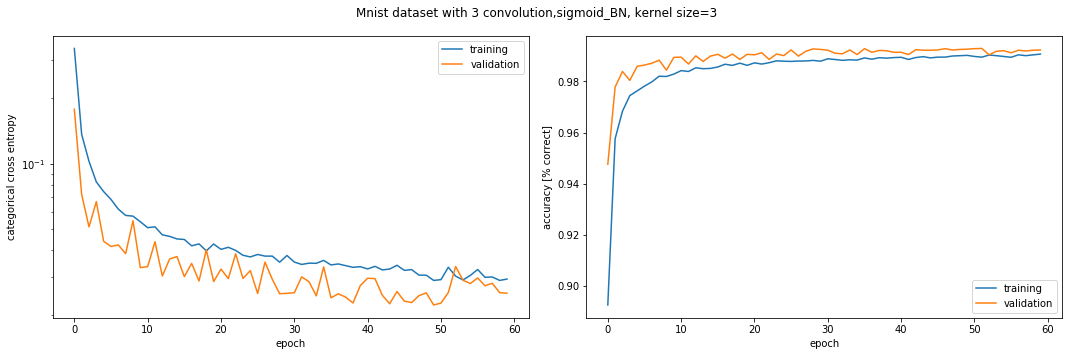

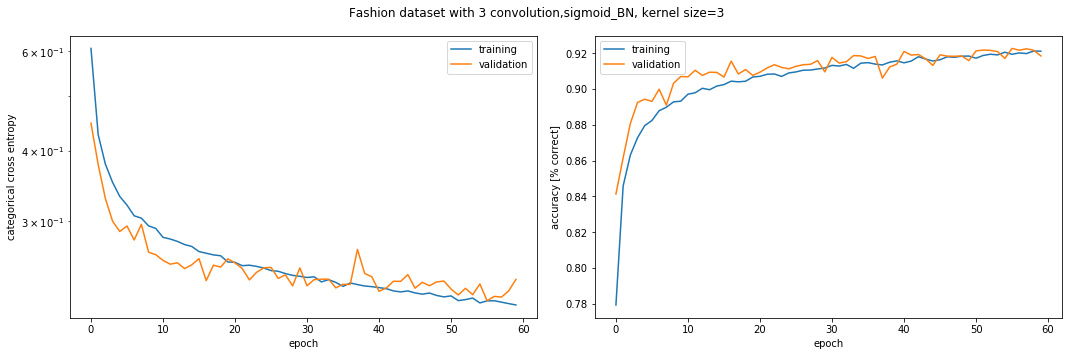

In [39]:
plot_history(minist_sigmoidbn_3cov[3],'Mnist dataset with 3 convolution,sigmoid_BN, kernel size=3'); 
plot_history(fashion_sigmoidbn_3cov[3],'Fashion dataset with 3 convolution,sigmoid_BN, kernel size=3'); 

Answer to question 1:

Answer to question 2: